<a href="https://colab.research.google.com/github/neetinds/Capstone3/blob/main/Capstone3_Data_science_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To identify the factors that lead to attrition with the goal of building a model that uses credentials of the candidate and various demographics factors to predict the probability of a candidate to look out for new jobs or remain at the company. 
#Using modeling technique like clustering, classification, smote, xgboost-classifier etc.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#MOUNT THE GDRIVE TO LOAD THE DATA

In [7]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#TRAIN DATA LOADED INTO DATAFAME, SELECT THE 10 ROWS

In [8]:
train=pd.read_csv('/content/gdrive/MyDrive/Springboard-master/Capstone 3/aug_train.csv')
train=train.sample(frac=1,random_state=10).reset_index().drop('index',axis=1)
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,0.847,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,114,0.0
1,27035,city_167,0.921,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,10,0.0
2,21753,city_21,0.624,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,214,0.0
3,27579,city_97,0.925,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,111,0.0
4,22405,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,60,0.0


#CHECK THE ROWS & COL

In [9]:
train.shape

(19158, 14)

#CHECK THE DATATYPE OF ALL COL'S

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

# Check the - Null/missing values across col's

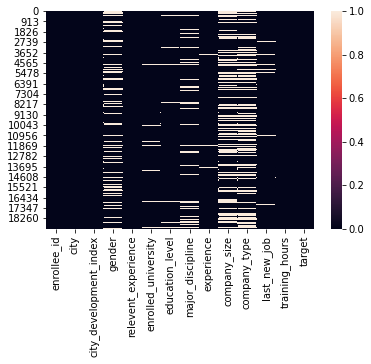

In [11]:
# Total Null values in the data set
sns.heatmap(train.isnull())
plt.show()

In [12]:
# Proportion of Null values in each column
propnull=train.isnull().sum()/len(train)
propnull

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

#REMOVE SAMPLES FROM COL'S WHERE THEY ARE LESS THAN 10%

In [13]:
# Removing samples with null values in columns containing less than 10% null values
sub=propnull[(propnull>0) & (propnull<0.1)].index
train.dropna(subset=sub,inplace=True)
train.shape

(18014, 14)

# EXPLORATORY DATA ANALYSIS(EDA), FEATURE ENGINEERING & DATA PREPROCESSING

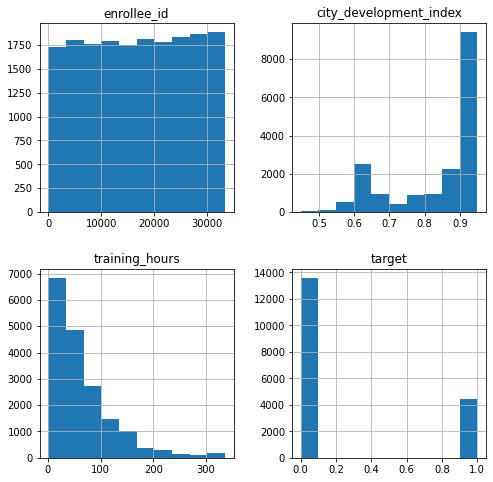

In [14]:
train.hist(figsize=(8,8))
plt.show()

# IDENTIFYING THE NUMERIC DATATYPES & RUNNING THE  TRANSFORMATIONS ON THEM

In [15]:
# Numeric Columns
num=train.select_dtypes(include='number')
num.head()

,enrollee_id,city_development_index,training_hours,target
0,20753,0.847,114,0.0
1,27035,0.921,10,0.0
2,21753,0.624,214,0.0
3,27579,0.925,111,0.0
4,22405,0.910,60,0.0


In [16]:
num.shape

(18014, 4)

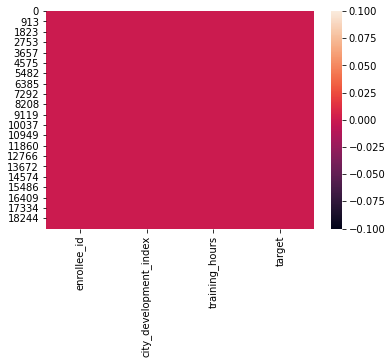

In [17]:
# Checking for null values
sns.heatmap(num.isnull())
plt.show()

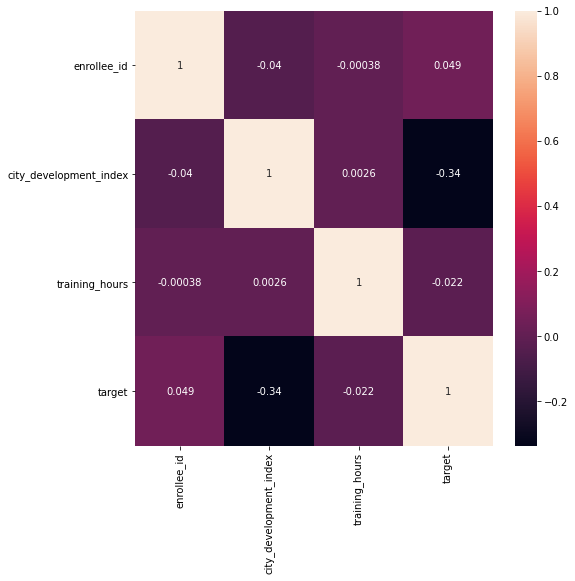

In [18]:
# Correlation for checking multicollinearity in numeric data and looking out for features having high impact on target
plt.figure(figsize=(8,8))
sns.heatmap(num.corr(),annot=True)
plt.show()

In [19]:
# Checking for duplicates in Enrollee ID (Id-Variable)
num['enrollee_id'].nunique()==len(train)

True

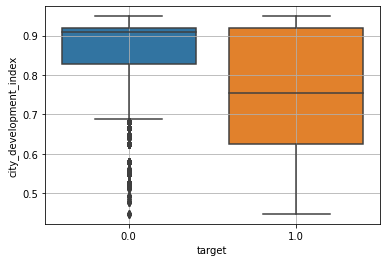

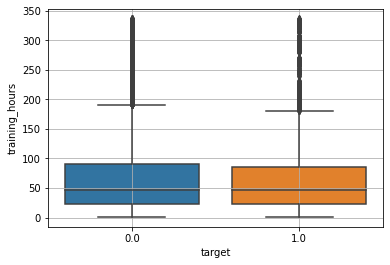

In [20]:
# Bivariate analysis of numeric features(after droping target and Id-variable) with target

n=num.drop(['target','enrollee_id'],axis=1) # Numeric features after droping target and Id-variable
for i in n:
    sns.boxplot(num['target'],n[i])
    plt.grid()
    plt.show()

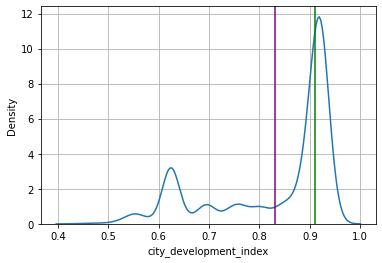

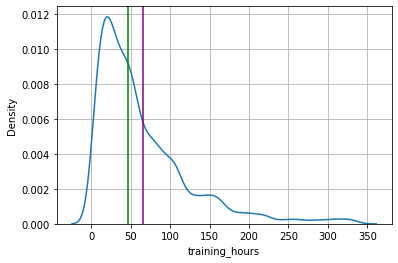

In [21]:
# Univariate or single variable analysis of numeric features after droping target and Id-variable
for i in n.columns: 
    sns.distplot(n[i],hist=False)
    plt.axvline(np.mean(n[i]),color='purple')
    plt.axvline(np.median(n[i]),color='green')
    plt.grid()
    plt.show()

In [22]:
# Checking minimum to look out for missing values
n.describe()    

,city_development_index,training_hours
count,18014.000000,18014.000000
mean,0.831728,65.347896
std,0.122115,60.059220
min,0.448000,1.000000
25%,0.745000,23.000000
50%,0.910000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


In [23]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,0.847,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,114,0.0
1,27035,city_167,0.921,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,10,0.0
2,21753,city_21,0.624,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,214,0.0
3,27579,city_97,0.925,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,111,0.0
4,22405,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,60,0.0


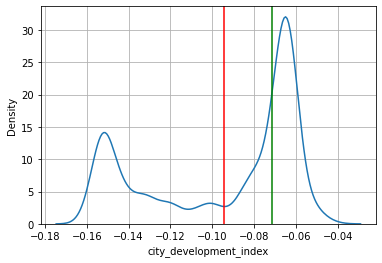

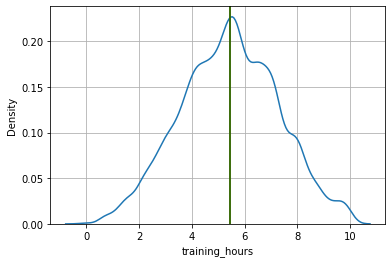

In [24]:
# Trying Boxcox tranformation on the numeric features to check skewness and distribution
import scipy.stats as stats
for i in n.columns:
    sns.distplot(stats.boxcox(n[i])[0],hist=False)
    plt.axvline(np.mean(stats.boxcox(n[i])[0]),color='red')
    plt.axvline(np.median(stats.boxcox(n[i])[0]),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

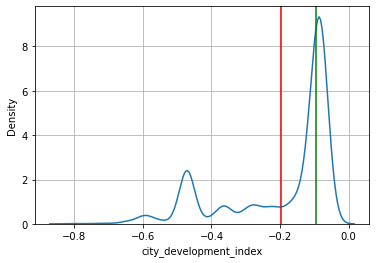

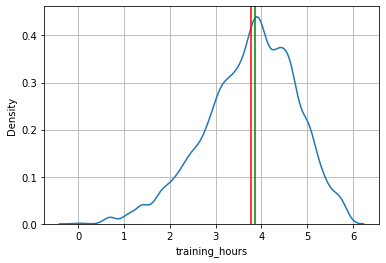

In [25]:
# Trying Log tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(np.log(n[i]),hist=False)
    plt.axvline(np.mean(np.log(n[i])),color='red')
    plt.axvline(np.median(np.log(n[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

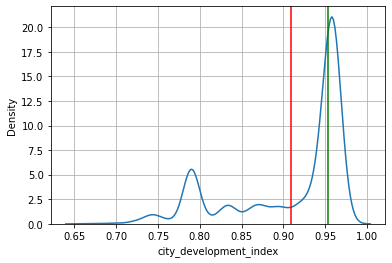

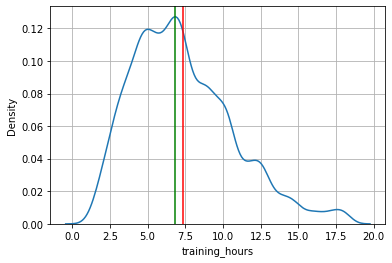

In [26]:
# Trying sqrt tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(np.sqrt(n[i]),hist=False)
    plt.axvline(np.mean(np.sqrt(n[i])),color='red')
    plt.axvline(np.median(np.sqrt(n[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

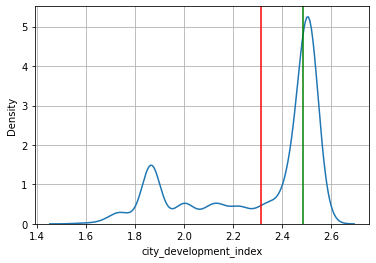

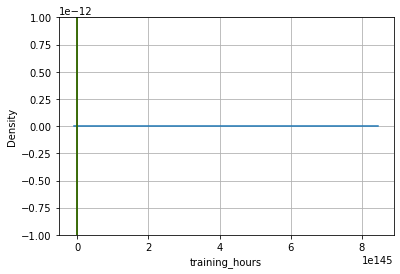

In [27]:
# Trying exponential tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(np.exp(n[i]),hist=False)
    plt.axvline(np.mean(np.exp(n[i])),color='red')
    plt.axvline(np.median(np.exp(n[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

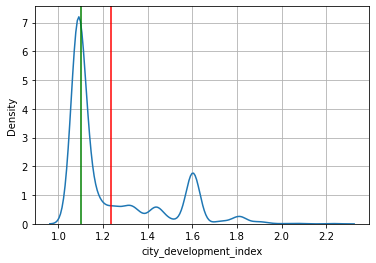

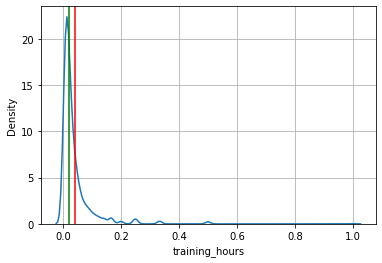

In [28]:
# Trying inverse tranformation on the numeric features to check skewness and distribution
for i in n.columns:
    sns.distplot(1/n[i],hist=False)
    plt.axvline(np.mean(1/n[i]),color='red')
    plt.axvline(np.median(1/n[i]),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

In [29]:
# Transforming the numeric features (target and id variable not included) using Boxcox Transformation
for i in n:
    n[i]=stats.boxcox(n[i])[0]
n.head()

,city_development_index,training_hours
0,-0.103387,7.304179
1,-0.064359,2.823142
2,-0.151783,8.801794
3,-0.061730,7.244260
4,-0.071285,5.935420


In [30]:
# Updating these transformations onto the train set
for i in n.columns:
    train[i]=n[i]
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,-0.103387,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,7.304179,0.0
1,27035,city_167,-0.064359,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,2.823142,0.0
2,21753,city_21,-0.151783,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,8.801794,0.0
3,27579,city_97,-0.061730,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,7.244260,0.0
4,22405,city_16,-0.071285,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,5.935420,0.0


In [31]:
# Scalling these transformed numeric features
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

train[n.columns]=sc.fit_transform(train[n.columns])
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,city_1,-0.244037,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1,1.011196,0.0
1,27035,city_167,0.825214,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1,-1.418698,0.0
2,21753,city_21,-1.569897,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1,1.823295,0.0
3,27579,city_97,0.897221,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1,0.978704,0.0
4,22405,city_16,0.635462,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4,0.268970,0.0


In [32]:
train.shape

(18014, 14)

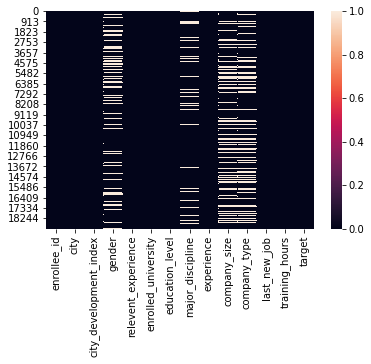

In [33]:
sns.heatmap(train.isnull())
plt.show()

In [34]:
train.isnull().sum()/len(train)

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.214444
relevent_experience       0.000000
enrolled_university       0.000000
education_level           0.000000
major_discipline          0.123349
experience                0.000000
company_size              0.294771
company_type              0.303986
last_new_job              0.000000
training_hours            0.000000
target                    0.000000
dtype: float64

# CATEGORIC DATA

In [35]:
categ=train.select_dtypes(include='object')
categ.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_1,Male,No relevent experience,Full time course,High School,NaN,4,10000+,Pvt Ltd,1
1,city_167,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1
2,city_21,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1
3,city_97,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1
4,city_16,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4


In [36]:
categ.shape

(18014, 10)

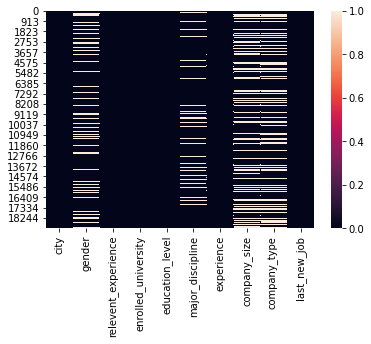

In [37]:
sns.heatmap(categ.isnull())
plt.show()

In [38]:
# Proprtion of null in each feature
propnc=categ.isnull().sum()/len(train)
propnc

city                   0.000000
gender                 0.214444
relevent_experience    0.000000
enrolled_university    0.000000
education_level        0.000000
major_discipline       0.123349
experience             0.000000
company_size           0.294771
company_type           0.303986
last_new_job           0.000000
dtype: float64

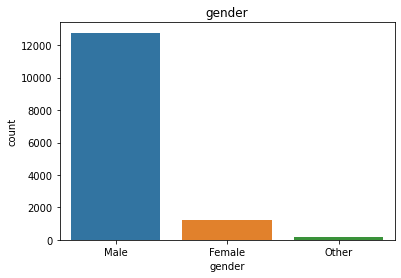

        Proportion % 
Male        70.900411
Female       6.694793
Other        0.960364


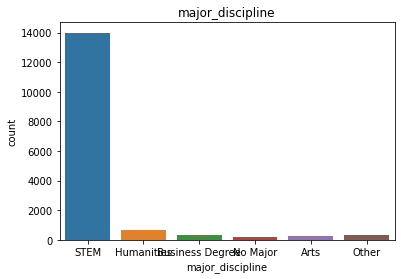

                 Proportion % 
STEM                 77.678472
Humanities            3.624958
Other                 2.020651
Business Degree       1.787499
Arts                  1.376707
No Major              1.176862


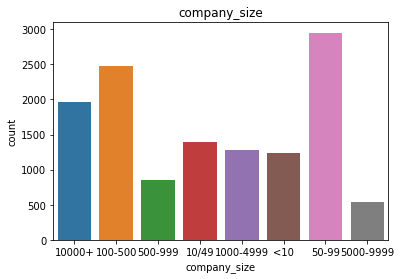

           Proportion % 
50-99          16.376152
100-500        13.783724
10000+         10.902631
10/49           7.738426
1000-4999       7.116687
<10             6.894638
500-999         4.701899
5000-9999       3.008771


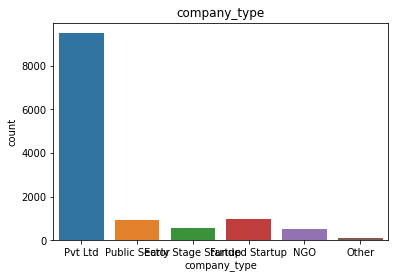

                     Proportion % 
Pvt Ltd                  52.597979
Funded Startup            5.412457
Public Sector             5.062729
Early Stage Startup       3.119796
NGO                       2.775619
Other                     0.632841


In [39]:
# Univariate analysis on categoric features with more than 10% null values
# Percentage Proportion of categoric groups in the feature with null>10% for identiying dominant groups

nc=propnc[propnc>0.1].index # Index of categoric features with more than 10% null values
for i in nc:
    plt.title(i)
    sns.countplot(categ[i])
    plt.show()
    a=100*categ[i].value_counts()/len(categ)
    a=pd.DataFrame(a).rename({i:'Proportion % '},axis=1)
    print(a)

In [40]:
# Identifying the most Dominant categories in each feature dominating more than 50% of the total counts of that feature

domin=[] # List of the most Dominant categories in each feature dominating more than 50% of the total counts of that feature
dfeat=[] # Features associated with these 'most' dominant categories

ndfeat=[] # Features that had most dominant category not being so dominant (less than 50%) 

for i in nc:                    # nc is the index of categorical features with >10% null
    maxi=categ[i].value_counts().max()    # Count of the most dominant group
    dom=categ[i].value_counts().idxmax()  # Most dominant group in the feature
    
    if maxi/len(categ)>=0.5:    # Filtering out ONLY those dominant categories that dominate >=50% proportion in that feature
        domin.append(dom)
        dfeat.append(i)
    else:
        ndfeat.append(i)
        
mstdmnt=pd.DataFrame({'Most Dominant Categories':domin,'Feature':dfeat}) # Tabular representation of dominant categories and the features that contain them
print(mstdmnt)
print()
print('Features with not so dominant labels: ',ndfeat) # List of features with 'not so dominant' dominant labels

  Most Dominant Categories           Feature
0                     Male            gender
1                     STEM  major_discipline
2                  Pvt Ltd      company_type

Features with not so dominant labels:  ['company_size']


##### Null value imputaion

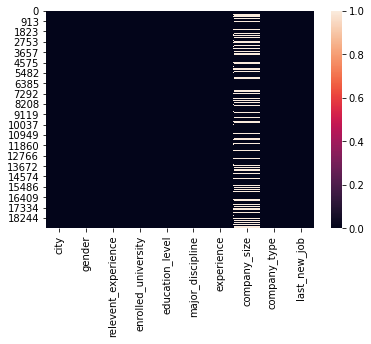

In [41]:
# Replacing Null of features with the 'most' dominant categories for features with dominant class that occupies more than 50% of the feature

categ=train.select_dtypes(include='object')

for i in mstdmnt.values:
    categ[i[1]].fillna(i[0],inplace=True)

sns.heatmap(categ.isnull())
plt.show()

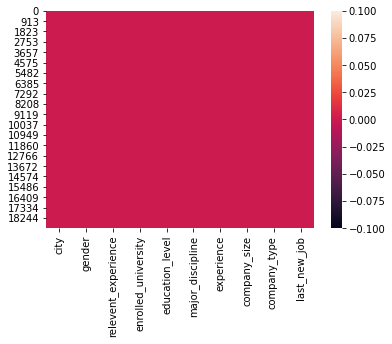

In [42]:
# Replacing null of features as 'OTHERS' for those features whose most dominant class is 'not so dominant' (ei occupy less than 50%)

for i in ndfeat: # List of features with 'not so dominant' dominant labels
    categ[i].fillna('OTHERS',inplace=True)

sns.heatmap(categ.isnull())
plt.show()

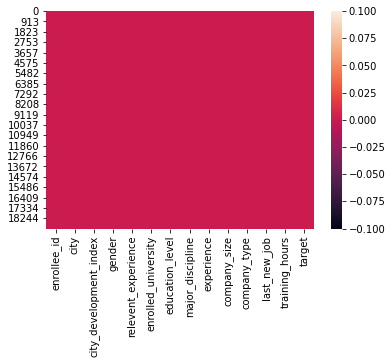

In [43]:
# Updating training set with clean categoric features
train[categ.columns]=categ

sns.heatmap(train.isnull())
plt.show()

In [44]:
train.shape

(18014, 14)

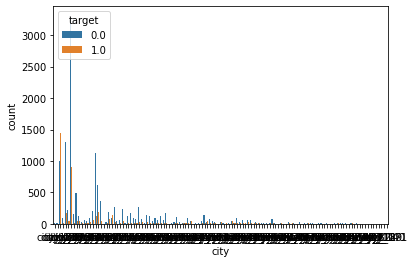

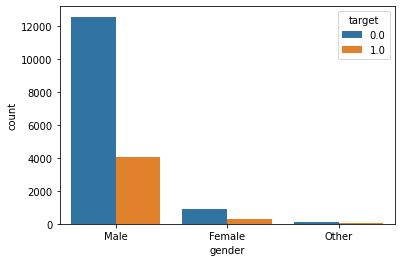

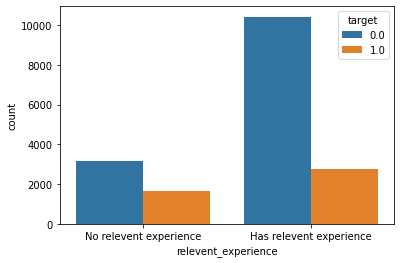

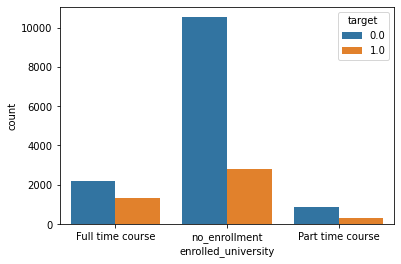

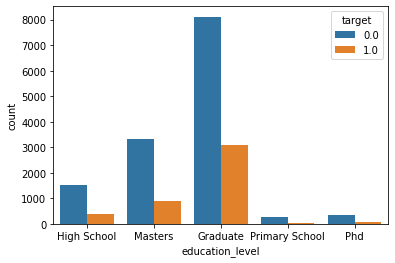

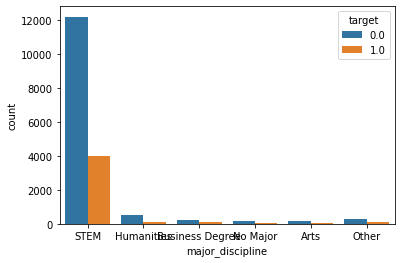

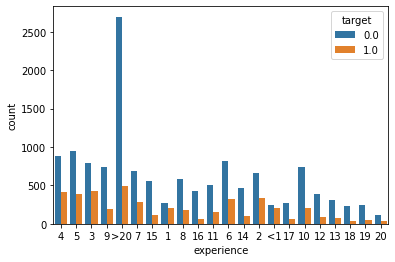

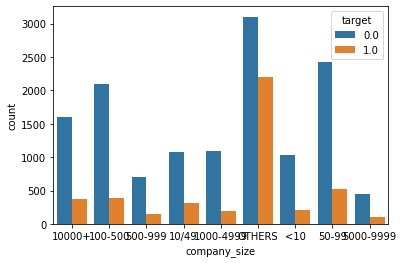

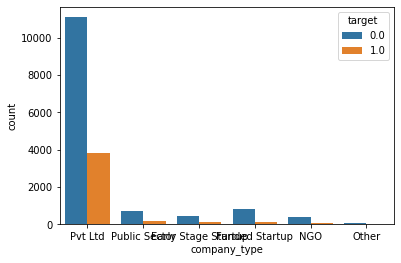

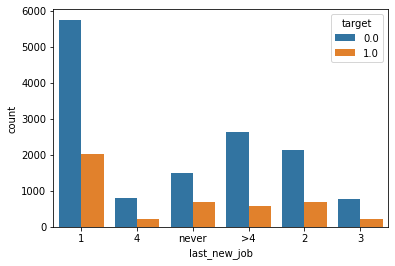

In [45]:
# Bivariate analysis of categorical features against the target
for i in categ:
    sns.countplot(categ[i],hue=train['target'])
    plt.show()

#### Collapsing categories of categoric features with many levels by Clustering

In [46]:
categ.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_1,Male,No relevent experience,Full time course,High School,STEM,4,10000+,Pvt Ltd,1
1,city_167,Male,Has relevent experience,Full time course,Masters,STEM,5,100-500,Pvt Ltd,1
2,city_21,Female,Has relevent experience,no_enrollment,Graduate,STEM,3,10000+,Pvt Ltd,1
3,city_97,Male,Has relevent experience,Full time course,Graduate,STEM,9,100-500,Public Sector,1
4,city_16,Male,Has relevent experience,no_enrollment,Graduate,STEM,9,500-999,Pvt Ltd,4


In [47]:
categ.shape

(18014, 10)

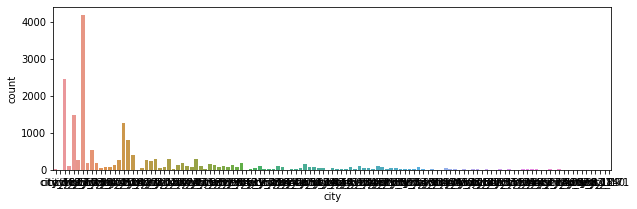

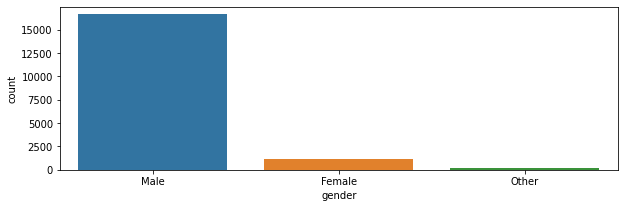

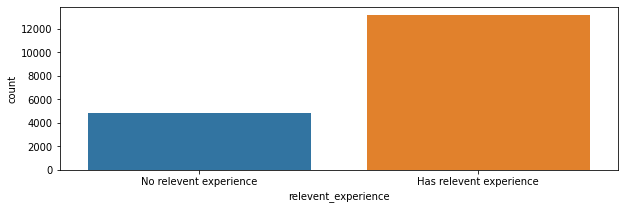

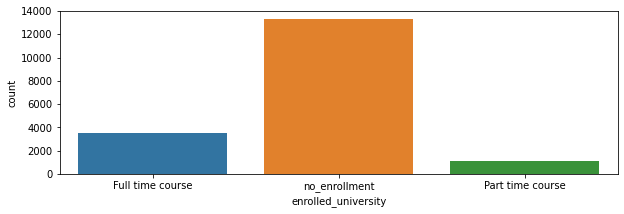

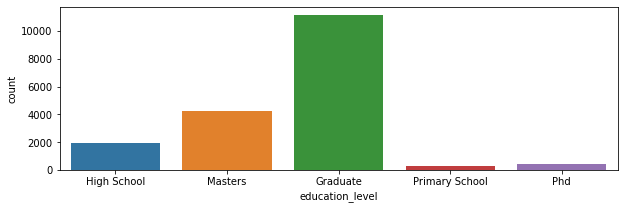

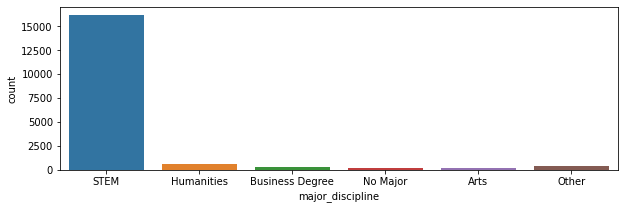

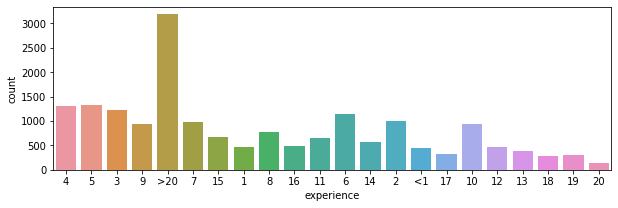

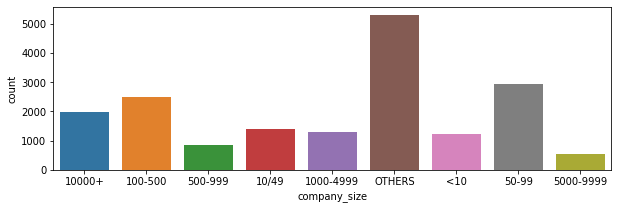

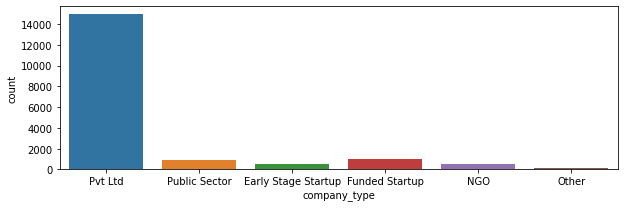

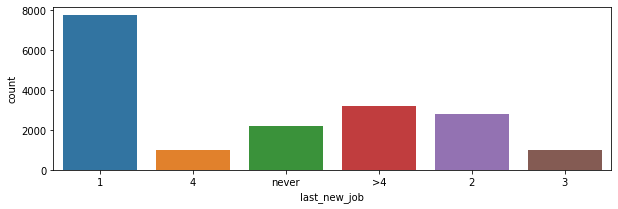

In [48]:
# Visualizing the label distributions among cateforic features
for i in categ:
    plt.figure(figsize=(10,3))
    sns.countplot(categ[i])
    plt.show()

In [49]:
desc=categ.describe()
desc

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,18014,18014,18014,18014,18014,18014,18014,18014,18014,18014
unique,123,3,2,3,5,6,22,9,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,OTHERS,Pvt Ltd,1
freq,4194,16635,13190,13348,11188,16215,3182,5310,14951,7789


In [50]:
# Checking the number of levels in each categoric feature
n_grp=pd.DataFrame(desc.iloc[1,:],index=desc.columns).rename({'unique':'Number of levels'},axis=1)
n_grp

,Number of levels
city,123
gender,3
relevent_experience,2
enrolled_university,3
education_level,5
major_discipline,6
experience,22
company_size,9
company_type,6
last_new_job,6


In [51]:
# Filtering out features with more than 6 levels
manylevelfeat=n_grp[n_grp['Number of levels']>6]

colps=list(manylevelfeat.index)   # Names of features with more than 6 levels (to be collapsed)

print(manylevelfeat)
print()
print(colps) 

             Number of levels
city                      123
experience                 22
company_size                9

['city', 'experience', 'company_size']


In [52]:
# Features to be collapsed
colps

['city', 'experience', 'company_size']

#Elbow plot to check alternate number of levels to represent these feature :

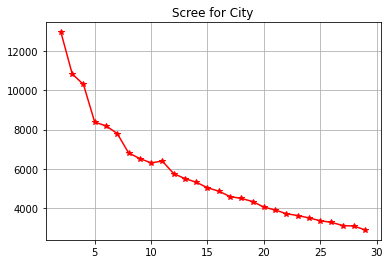

In [53]:
from sklearn.cluster import KMeans

dumcity=pd.get_dummies(categ['city'],drop_first=True)

inert_city=[]
for k in range(2,30):
    kcity=KMeans(k)
    kcity.fit(dumcity)
    
    inert_city.append(kcity.inertia_)

plt.title('Scree for City')
plt.plot(range(2,30),inert_city,color='red',marker='*')
plt.grid()
plt.show()

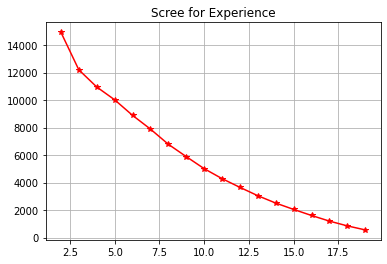

In [54]:
dumexp=pd.get_dummies(categ['experience'],drop_first=True)

inert_exp=[]
for k in range(2,20):
    kexp=KMeans(k)
    kexp.fit(dumexp)
    
    inert_exp.append(kexp.inertia_)
    
plt.title('Scree for Experience')
plt.plot(range(2,20),inert_exp,color='red',marker='*')
plt.grid()
plt.show()

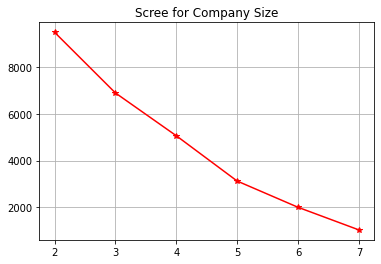

In [55]:
dumcpsize=pd.get_dummies(categ['company_size'],drop_first=True)

inert_cpsz=[]
for k in range(2,8):
    kcpsz=KMeans(k)
    kcpsz.fit(dumcpsize)
    
    inert_cpsz.append(kcpsz.inertia_)

plt.title('Scree for Company Size')
plt.plot(range(2,8),inert_cpsz,color='red',marker='*')
plt.grid()
plt.show()

Collapsing levels :

In [56]:
# Collapsed city from 123 to 15 levels
kmeancity=KMeans(n_clusters=15)
kmeancity.fit(dumcity)

city=kmeancity.labels_
city

array([13, 13,  2, ...,  1,  0,  5], dtype=int32)

In [57]:
# Collapsed experience from 22 to 10 levels
kmeanexp=KMeans(n_clusters=10)
kmeanexp.fit(dumexp)

exp=kmeanexp.labels_
exp

array([2, 3, 7, ..., 1, 0, 7], dtype=int32)

In [58]:
# Collapsed company size from 9 to 5 levels
kmeancpsize=KMeans(n_clusters=5)
kmeancpsize.fit(dumcpsize)

cpsize=kmeancpsize.labels_
cpsize

array([4, 3, 4, ..., 2, 4, 1], dtype=int32)

In [59]:
categ['city']=city
categ['experience']=exp
categ['company_size']=cpsize

categ.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,13,Male,No relevent experience,Full time course,High School,STEM,2,4,Pvt Ltd,1
1,13,Male,Has relevent experience,Full time course,Masters,STEM,3,3,Pvt Ltd,1
2,2,Female,Has relevent experience,no_enrollment,Graduate,STEM,7,4,Pvt Ltd,1
3,13,Male,Has relevent experience,Full time course,Graduate,STEM,6,3,Public Sector,1
4,5,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,0,Pvt Ltd,4


In [60]:
categ[colps].head()

,city,experience,company_size
0,13,2,4
1,13,3,3
2,2,7,4
3,13,6,3
4,5,6,0


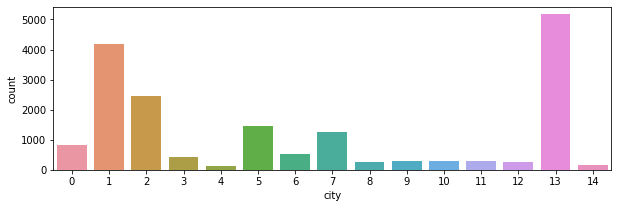

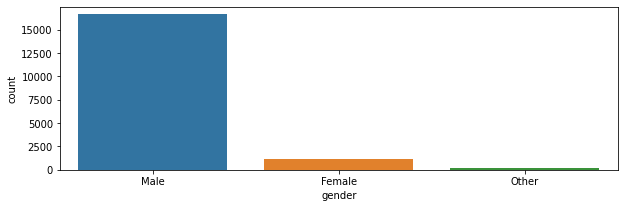

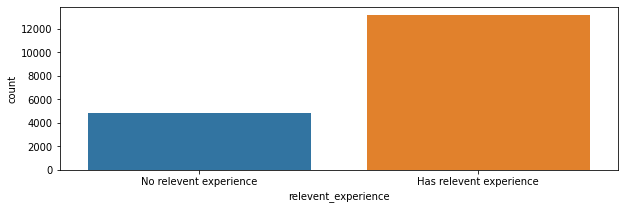

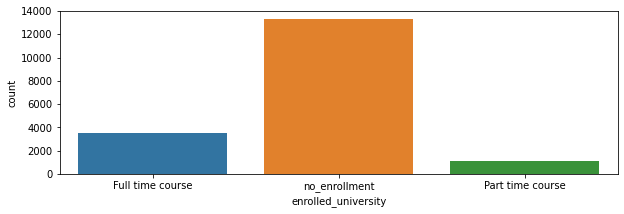

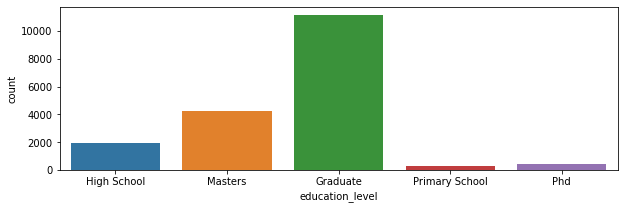

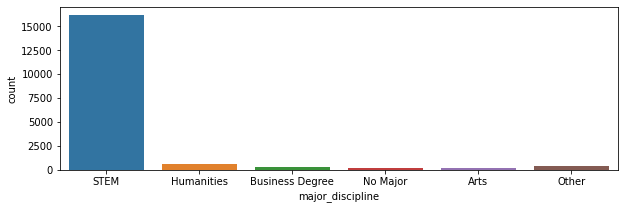

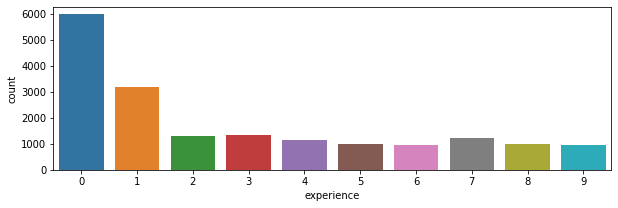

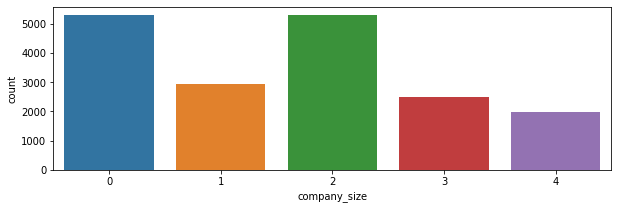

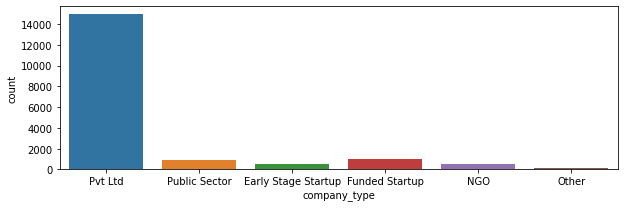

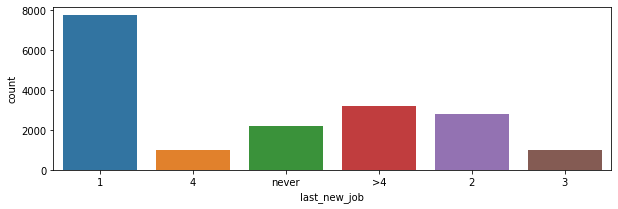

In [61]:
# Visualizing the label distributions among cateforic features after collapse (ALL categoric features included)
for i in categ:
    plt.figure(figsize=(10,3))
    sns.countplot(categ[i])
    plt.show()

In [62]:
# Final updation on the train set with collapsed features thier compressed levels
train[colps]=categ[colps]
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,20753,13,-0.244037,Male,No relevent experience,Full time course,High School,STEM,2,4,Pvt Ltd,1,1.011196,0.0
1,27035,13,0.825214,Male,Has relevent experience,Full time course,Masters,STEM,3,3,Pvt Ltd,1,-1.418698,0.0
2,21753,2,-1.569897,Female,Has relevent experience,no_enrollment,Graduate,STEM,7,4,Pvt Ltd,1,1.823295,0.0
3,27579,13,0.897221,Male,Has relevent experience,Full time course,Graduate,STEM,6,3,Public Sector,1,0.978704,0.0
4,22405,5,0.635462,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,0,Pvt Ltd,4,0.268970,0.0


In [63]:
# One-hot encoding of all categoric features of train set
train=pd.get_dummies(data=train,columns=list(categ.columns),drop_first=True)
train.head()

,enrollee_id,city_development_index,training_hours,target,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,experience_1,experience_2,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,company_size_1,company_size_2,company_size_3,company_size_4,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,20753,-0.244037,1.011196,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,27035,0.825214,-1.418698,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,21753,-1.569897,1.823295,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,27579,0.897221,0.978704,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,22405,0.635462,0.268970,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [64]:
train.shape

(18014, 55)

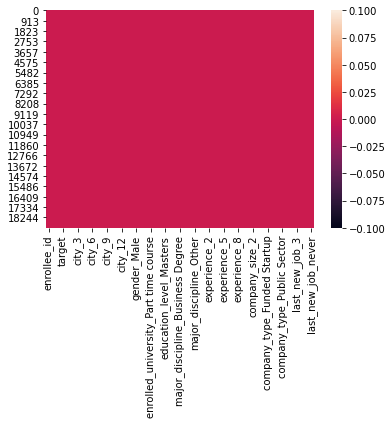

In [65]:
sns.heatmap(train.isnull())
plt.show()

#Oversampling

In [66]:
Y=train['target']
X=train.drop(['target','enrollee_id'],axis=1) # Id varibale is not going to considered

In [67]:
# Check for Data imbalance
train['target'].value_counts()

0.0    13593
1.0     4421
Name: target, dtype: int64

SMOTE : Is an oversampling technique where the synthetic samples are generated for the minority class

In [68]:
# Balancing data using SMOTE
from imblearn.over_sampling import SMOTE
from pandas import Series
smt=SMOTE(k_neighbors=9,random_state=10)

X,Y=smt.fit_resample(X,Y)


In [69]:
print(X)
print(Y)

[[-0.24403668  1.01119603  0.         ...  0.          0.
   0.        ]
 [ 0.82521375 -1.41869776  0.         ...  0.          0.
   0.        ]
 [-1.56989681  1.82329474  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.80746641 -1.31023176  1.         ...  0.          0.
   0.22486129]
 [-1.07973108  1.26121788  0.         ...  0.          0.
   0.        ]
 [-1.56989681  0.51570937  0.         ...  0.          0.
   0.        ]]
[0. 0. 0. ... 1. 1. 1.]


In [70]:
# Imbalance fixed
#Y.value_counts()


#### MODELING

In [71]:
from sklearn.model_selection import train_test_split
Xtr,Xte,Ytr,Yte=train_test_split(X,Y,test_size=0.02,random_state=10)

Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression
log=LogisticRegression(random_state=10)
log.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',log.score(Xtr,Ytr))
print('Test accuracy :',log.score(Xte,Yte))

Train accuracy : 0.7712258839426469
Test accuracy : 0.7830882352941176


In [73]:
# Check for Bais
from sklearn.model_selection import KFold,cross_val_score
cvs=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(log,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.76917014 0.76556694 0.77466216]
Recall : [0.75965665 0.76028175 0.753125  ]
Precision : [0.77307867 0.77808728 0.77605013]
F1 : [0.7621518  0.76745261 0.77001472]


In [74]:
# Predictions
from sklearn.model_selection import cross_val_predict
ylog=cross_val_predict(log,Xte,Yte,cv=KFold(n_splits=3,shuffle=True))
ylogprob=cross_val_predict(log,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

Naive Bayes

In [75]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()
nb.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',nb.score(Xtr,Ytr))
print('Test accuracy :',nb.score(Xte,Yte))

Train accuracy : 0.6502890173410405
Test accuracy : 0.7113970588235294


In [76]:
# Check for Bais
cvs=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(nb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.64812521 0.65307961 0.64876126]
Recall : [0.83824522 0.83608784 0.82298695]
Precision : [0.60721344 0.6106959  0.6125904 ]
F1 : [0.70469287 0.70769813 0.69791567]


In [77]:
# Predictions
ynb=cross_val_predict(nb,Xte,Yte,cv=KFold(n_splits=3,shuffle=True))
ynbprob=cross_val_predict(nb,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

Decision Tree

In [78]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier(max_leaf_nodes=32,random_state=10)
dt.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',dt.score(Xtr,Ytr))
print('Test accuracy :',dt.score(Xte,Yte))

Train accuracy : 0.803843555288642
Test accuracy : 0.8161764705882353


In [79]:
# Check for Bais
cvs=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(dt,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.81071951 0.80137372 0.8027027 ]
Recall : [0.79235348 0.7982929  0.82263815]
Precision : [0.80667563 0.78454647 0.79961173]
F1 : [0.80904356 0.80013482 0.80225098]


In [80]:
# Predictions
ydt=cross_val_predict(dt,Xte,Yte,cv=KFold(n_splits=3,shuffle=True))
ydtprob=cross_val_predict(dt,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

SVC

In [81]:
from sklearn.svm import SVC
svm=SVC(probability=True)
svm.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',svm.score(Xtr,Ytr))
print('Test accuracy :',svm.score(Xte,Yte))

Train accuracy : 0.8275279633661137
Test accuracy : 0.8216911764705882


In [82]:
# Check for Bais
cvs=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(svm,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.81004391 0.80385092 0.80326577]
Recall : [0.81962384 0.80310531 0.80566165]
Precision : [0.80650995 0.80479069 0.80418636]
F1 : [0.80296396 0.80699787 0.80651363]


In [84]:
# Predictions
ysvm=cross_val_predict(svm,Xte,Yte,cv=2)
ysvmprob=cross_val_predict(svm,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

KNN

In [85]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(Xtr,Ytr)

#Check for Variance:
print('Train accuracy :',knn.score(Xtr,Ytr))
print('Test accuracy :',knn.score(Xte,Yte))

Train accuracy : 0.8422791081750619
Test accuracy : 0.7922794117647058


In [86]:
# Check for Bais
cvs=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(knn,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.78110573 0.77941673 0.77713964]
Recall : [0.89033708 0.88540958 0.88025163]
Precision : [0.73409218 0.73542016 0.72211861]
F1 : [0.79476697 0.80256202 0.7990176 ]


In [87]:
# Predictions
yknn=cross_val_predict(knn,Xte,Yte,cv=3)
yknnprob=cross_val_predict(knn,Xte,Yte,cv=KFold(n_splits=3,shuffle=True),method='predict_proba')

ROC-AUC scores and ROC curves to select Base Model: 
The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

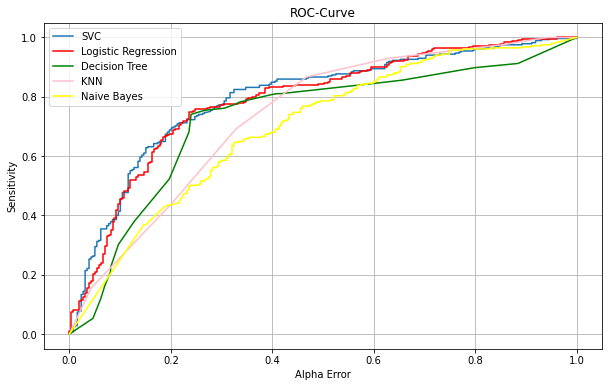

ROCAUC Logistic Regression : 0.7889182415498205
ROCAUC SVC : 0.7963557542504911
ROCAUC KNN : 0.7350809456072614
ROCAUC Decision Tree : 0.728056628056628
ROCAUC Naive Bayes : 0.6979678927047348


In [88]:
from sklearn.metrics import roc_auc_score,roc_curve

plt.figure(figsize=(10,6))

# SVC:
asvm,recsvm,thsvm=roc_curve(Yte,ysvmprob[:,1])
plt.plot(asvm,recsvm,label='SVC')

# Logistic Regression:
alog,reclog,thlog=roc_curve(Yte,ylogprob[:,1])
plt.plot(alog,reclog,color='red',label='Logistic Regression')

# Decision Tree:
adt,recdt,thdt=roc_curve(Yte,ydtprob[:,1])
plt.plot(adt,recdt,color='green',label='Decision Tree')

# KNN:
aknn,recknn,thknn=roc_curve(Yte,yknnprob[:,1])
plt.plot(aknn,recknn,color='pink',label='KNN')

# Naive Bayes:
anb,recknb,thnb=roc_curve(Yte,ynbprob[:,1])
plt.plot(anb,recknb,color='yellow',label='Naive Bayes')


plt.legend()
plt.grid()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC Logistic Regression :',roc_auc_score(Yte,ylogprob[:,1]))
print('ROCAUC SVC :',roc_auc_score(Yte,ysvmprob[:,1]))
print('ROCAUC KNN :',roc_auc_score(Yte,yknnprob[:,1]))
print('ROCAUC Decision Tree :',roc_auc_score(Yte,ydtprob[:,1]))
print('ROCAUC Naive Bayes :',roc_auc_score(Yte,ynbprob[:,1]))

BASEMODEL <====> Logistic Regression

In [89]:
#Hyperparameters for Randomsearch:
paramrand={'penalty':['l2','elasticnet'],
    'C':[0.07,0.5,1.0,1.5,2.0],
    'l1_ratio':[0.001,0.1,0.15,0.2,0.25,0.3,0.35,0.39,0.4,0.45,0.5,0.55],
    'tol':[0.0001,0.001,0.01,0.1],
    'class_weight':[None,'balanced'],
    'solver':['lbfgs','newton-cg', 'sag', 'saga'],
    'max_iter':[60,80,100,120,150],
    'multi_class':['auto','ovr'],
    'n_jobs':[None,-1]}

In [90]:
# Random Search CV:
from sklearn.model_selection import RandomizedSearchCV
randbase=RandomizedSearchCV(log,param_distributions=paramrand,scoring='roc_auc',cv=3,random_state=10,return_train_score=True)
randbase.fit(Xtr,Ytr)

randbase.best_params_

{'C': 1.5,
 'class_weight': 'balanced',
 'l1_ratio': 0.15,
 'max_iter': 150,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 0.0001}

In [91]:
randbase.best_estimator_

LogisticRegression(C=1.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.15,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
randbase.best_score_

0.8111890051791605

In [93]:
# Hyperparameters for fine tuning with Gridsearch:
paramgrid={'C':[3.25,3.5,3.75,3.8],  
           'l1_ratio':[0,0.002,0.005,0.009,0.01],
           'max_iter':[100,120],
          'class_weight':[None,'balanced']}

In [94]:
# Grid Search CV:
from sklearn.model_selection import GridSearchCV
gridbase=GridSearchCV(log,param_grid=paramgrid,scoring='roc_auc',cv=3)
gridbase.fit(Xtr,Ytr)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=10, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [3.25, 3.5, 3.75, 3.8],
                         'class_weight': [None, 'balanced'],
                         'l1_ratio': [0, 0.002, 0.005, 0.009, 0.01],
                         'max_iter': [100, 120]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [95]:
gridbase.best_params_

{'C': 3.25, 'class_weight': 'balanced', 'l1_ratio': 0, 'max_iter': 120}

In [96]:
gridbase.best_estimator_

LogisticRegression(C=3.25, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0,
                   max_iter=120, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [97]:
gridbase.best_score_

0.8112050188344746

In [98]:
# Base Model
base=LogisticRegression(C=3.5, l1_ratio=0, random_state=10,class_weight='balance')
base.fit(Xtr,Ytr)

print('Train accuracy :',base.score(Xtr,Ytr))
print('Test accuracy :',base.score(Xte,Yte))

Train accuracy : 0.7714135575407252
Test accuracy : 0.7830882352941176


In [99]:
# Accuracy,precision,recall and f1 of base model
cvs=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(base,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',np.mean(cvs))
print('Recall :',np.mean(cvsrec))
print('Precision :',np.mean(cvsprec))
print('F1 :',np.mean(cvsf1))

Accuracy : 0.7701376863858567
Recall : 0.7592280919467802
Precision : 0.7756280146807795
F1 : 0.7678892968771392


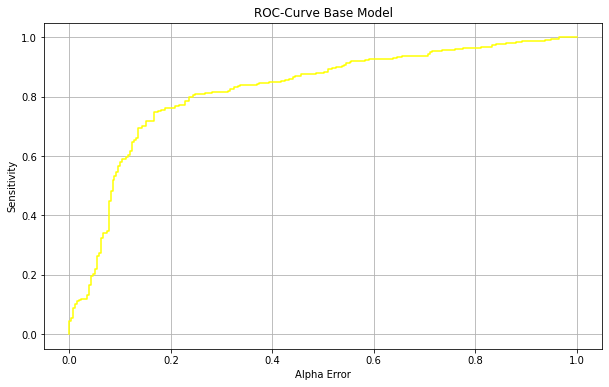

ROCAUC Base Model : 0.8220686852265799


In [100]:
plt.figure(figsize=(10,6))

abase,recbase,thbase=roc_curve(Yte,base.predict_proba(Xte)[:,-1])

plt.plot(abase,recbase,color='yellow')

plt.grid()
plt.title('ROC-Curve Base Model')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC Base Model :',roc_auc_score(Yte,base.predict_proba(Xte)[:,-1]))

In [101]:
from mlxtend.feature_selection import SequentialFeatureSelector
sfs=SequentialFeatureSelector(base,forward=False,k_features=5,cv=2)
sfs.fit(X,Y)

SequentialFeatureSelector(clone_estimator=True, cv=2,
                          estimator=LogisticRegression(C=3.5,
                                                       class_weight='balance',
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=0, max_iter=100,
                                                       multi_class='auto',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=10,
                                                       solver='lbfgs',
                                                       tol=0.0001, verbose=0,
                                                       warm_start=False),

In [102]:
# Important features:
sfs.k_feature_names_

('0', '14', '21', '24', '40')

### Ensemble

Random Forest

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
paramrand={'n_estimators':[300,100,150],
    'criterion':['gini','entropy'],
    'max_depth':[5,7,8,9,10,12],
    'max_leaf_nodes':range(8,33),
    'min_samples_split':[2,5,7,9,20,100],
    'min_samples_leaf':[1,2],
    'min_weight_fraction_leaf':[0.0,0.01,2,5,10],
    'max_features':['auto', 'sqrt', 'log2'],
    'min_impurity_decrease':[0.0,0.001,2,5,10],
    'min_impurity_split':[0.0,0.001,2,5,10],
    'oob_score':[False,True],
    'class_weight':[None,1,2,5,10,0,0.1],
    'ccp_alpha':[1,2,5,10,0,0.10],
    'max_samples':[None,1,400]}

In [105]:
randrf=RandomizedSearchCV(RandomForestClassifier(),param_distributions=paramrand,scoring='roc_auc')
randrf.fit(Xtr,Ytr)

randrf.best_params_

{'ccp_alpha': 10,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': 14,
 'max_samples': 1,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': 0.001,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.01,
 'n_estimators': 100,
 'oob_score': True}

In [106]:
randrf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=10, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=14, max_samples=1,
                       min_impurity_decrease=0.0, min_impurity_split=0.001,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.01, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [107]:
rf=RandomForestClassifier(max_leaf_nodes=32,max_depth=10,n_estimators=180,min_samples_leaf=2,
                          min_samples_split=2,min_impurity_split=0.0,criterion='gini',random_state=10)

rf.fit(Xtr,Ytr)

# Check for Variance
# Check for Variance
print('Train accuracy :',rf.score(Xtr,Ytr))
print('Test accuracy :',rf.score(Xte,Yte))

Train accuracy : 0.8036183469709481
Test accuracy : 0.8180147058823529


In [108]:
# Check for Bais
cvs=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(rf,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.80047292 0.80002252 0.80202703]
Recall : [0.80244444 0.8045691  0.82242991]
Precision : [0.79964302 0.7899271  0.79782994]
F1 : [0.80136364 0.80598682 0.80101702]


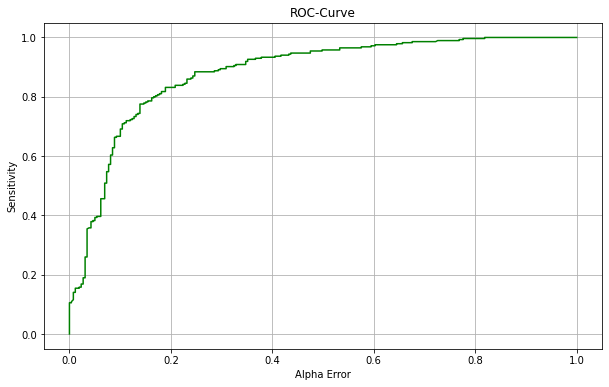

ROCAUC Random Forest : 0.8812436496647023


In [109]:
plt.figure(figsize=(10,6))

arf,recrf,thrf=roc_curve(Yte,rf.predict_proba(Xte)[:,1])

plt.plot(arf,recrf,color='green')

plt.grid()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC Random Forest :',roc_auc_score(Yte,rf.predict_proba(Xte)[:,1]))

XGBoost: Ensemble learning involves training and combining individual models (known as base learners) to get a single prediction, and XGBoost is one of the ensemble learning methods.

In [110]:
from xgboost import XGBClassifier

In [111]:
# Random Search
paramrand={'n_estimators':[70,100,130,150,180,200],
          'max_depth': [4,6,8,10,12],
          'learning_rate':['eta',0.5,0.1,0.05,0.8,1,1.3,1.5,2],
          'gamma': [0,0.001,0.03,0.05,0.07,0.1,0.2],
          'min_child_weight':[1,3,5,7],
          'colsample_bytree':[0.3,0.4,0.5,0.7],
          'booster':['gbtree', 'dart'], 
          'importance_type':['gain', 'weight', 'cover', 'total_gain','total_cover']}

In [112]:
randxgb=RandomizedSearchCV(XGBClassifier(eval_metric='error',random_state=10),param_distributions=paramrand,scoring='roc_auc',n_iter=12)
randxgb.fit(Xtr,Ytr)

randxgb.best_score_

0.9296062242844334

In [113]:
randxgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='error',
              gamma=0.05, learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=7, missing=None, n_estimators=130, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [114]:
randxgb.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.3,
 'gamma': 0.05,
 'importance_type': 'weight',
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 7,
 'n_estimators': 130}

In [115]:
xgb=XGBClassifier(n_estimators=150,max_depth=8,colsample_bytree=0.3,booster='gbtree',
                  min_child_weight=7,learning_rate=0.8,gamma=0.03,importance_type='cover',
                  eval_metric='error',random_state=10,)
xgb.fit(Xtr,Ytr)

# Check for Variance
print('Train accuracy :',xgb.score(Xtr,Ytr))
print('Test accuracy :',xgb.score(Xte,Yte))

Train accuracy : 0.9012461526912394
Test accuracy : 0.8805147058823529


In [116]:
# Check for Bais
cvs=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True))
cvsrec=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='recall')
cvsprec=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='precision')
cvsf1=cross_val_score(xgb,Xtr,Ytr,cv=KFold(n_splits=3,shuffle=True),scoring='f1')

print('Accuracy :',cvs)
print('Recall :',cvsrec)
print('Precision :',cvsprec)
print('F1 :',cvsf1)

Accuracy : [0.85294449 0.85362009 0.84414414]
Recall : [0.84507994 0.84339537 0.83366958]
Precision : [0.84899561 0.86916743 0.84892585]
F1 : [0.84897592 0.84370328 0.84353897]


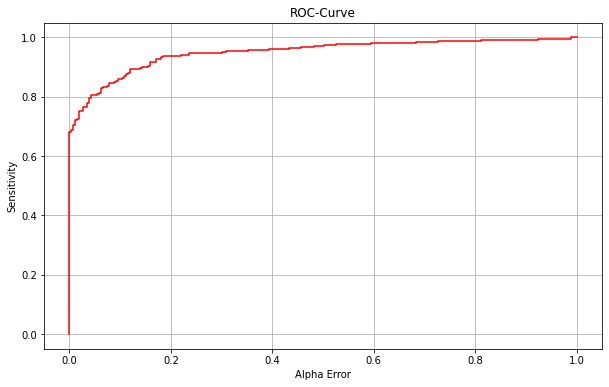

ROCAUC XGBoost : 0.9501591817381292


In [117]:
plt.figure(figsize=(10,6))

axgb,recxgb,thxgb=roc_curve(Yte,xgb.predict_proba(Xte)[:,1])

plt.plot(axgb,recxgb,color='red')

plt.grid()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC XGBoost :',roc_auc_score(Yte,xgb.predict_proba(Xte)[:,1]))

Model Comparison to select final model

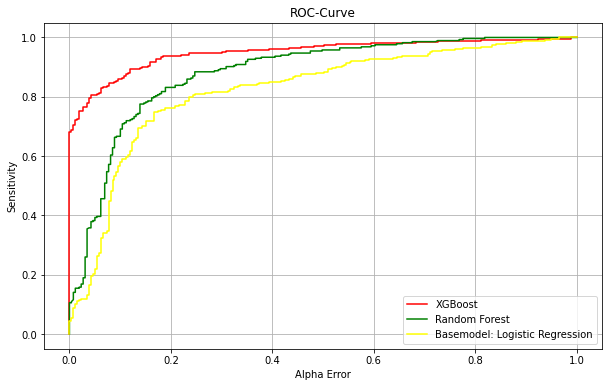

ROCAUC XGBoost : 0.9501591817381292
ROCAUC Random Forest : 0.8812436496647023
ROCAUC Base Model : 0.8220686852265799


In [118]:
plt.figure(figsize=(10,6))

axgb,recxgb,thxgb=roc_curve(Yte,xgb.predict_proba(Xte)[:,1])
plt.plot(axgb,recxgb,color='red',label='XGBoost')

arf,recrf,thrf=roc_curve(Yte,rf.predict_proba(Xte)[:,1])
plt.plot(arf,recrf,color='green',label='Random Forest')

abase,recbase,thbase=roc_curve(Yte,base.predict_proba(Xte)[:,-1])
plt.plot(abase,recbase,color='yellow',label='Basemodel: Logistic Regression')

plt.grid()
plt.legend()
plt.title('ROC-Curve')
plt.xlabel('Alpha Error')
plt.ylabel('Sensitivity')
plt.show()

print('ROCAUC XGBoost :',roc_auc_score(Yte,xgb.predict_proba(Xte)[:,1]))
print('ROCAUC Random Forest :',roc_auc_score(Yte,rf.predict_proba(Xte)[:,1]))
print('ROCAUC Base Model :',roc_auc_score(Yte,base.predict_proba(Xte)[:,-1]))

Final Model <====> XGBoost Classifier

In [119]:
final=XGBClassifier(n_estimators=160,max_depth=8,colsample_bytree=0.3,booster='gbtree',
                  min_child_weight=5,learning_rate=0.5,gamma=0.5,importance_type='total_cover',
                  eval_metric='error',random_state=10,)
final.fit(X,Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='error',
              gamma=0.5, learning_rate=0.5, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=160, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Test Set

In [120]:
test = pd.read_csv('/content/gdrive/MyDrive/Springboard-master/Capstone 3/aug_test.csv')
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [121]:
test.shape

(2129, 13)

In [122]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


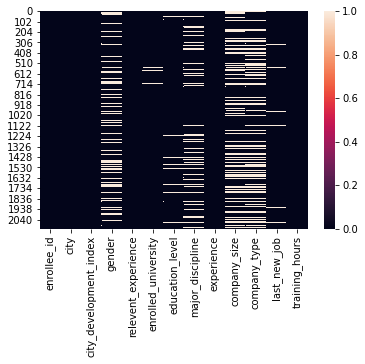

In [123]:
sns.heatmap(test.isnull())
plt.show()

In [124]:
propnulltest=100*(test.isnull().sum()/len(test))
propnulltest

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    23.860968
relevent_experience        0.000000
enrolled_university        1.456083
education_level            2.442461
major_discipline          14.654767
experience                 0.234852
company_size              29.215594
company_type              29.779239
last_new_job               1.878816
training_hours             0.000000
dtype: float64

In [125]:
subtest=list(propnulltest[(propnulltest<10) & (propnulltest>0)].index)
test.dropna(subset=subtest,inplace=True)
test.shape

(2018, 13)

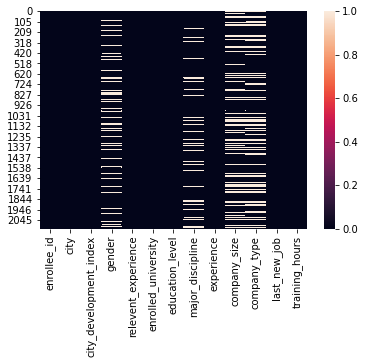

In [126]:
sns.heatmap(test.isnull())
plt.show()

In [127]:
# Numeric data
numtest=test.select_dtypes(include='number').drop('enrollee_id',axis=1)
numtest.head()

,city_development_index,training_hours
0,0.827,21
1,0.920,98
2,0.624,15
3,0.827,39
4,0.920,72


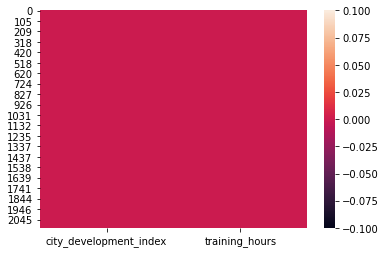

In [128]:
sns.heatmap(numtest.isnull())
plt.show()

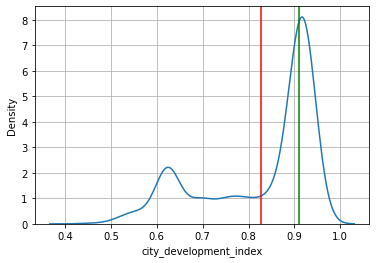

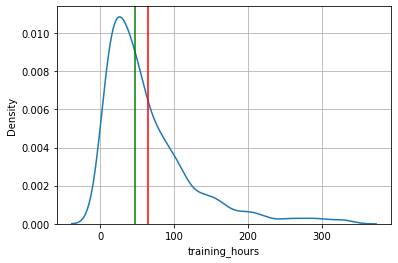

In [129]:
for i in numtest:
    sns.distplot(numtest[i],hist=False)
    plt.axvline(np.mean(numtest[i]),color='red')
    plt.axvline(np.median(numtest[i]),color='green')
    plt.grid()
    plt.show()

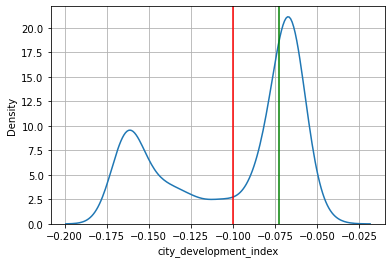

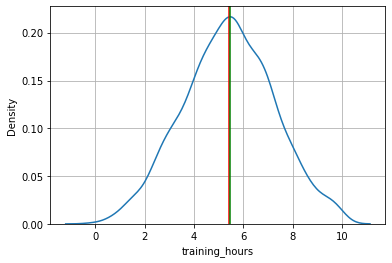

In [130]:
# Trying boxcox transform:
import scipy.stats as stats
for i in numtest:
    sns.distplot(stats.boxcox(numtest[i])[0],hist=False)
    plt.axvline(np.mean(stats.boxcox(numtest[i])[0]),color='red')
    plt.axvline(np.median(stats.boxcox(numtest[i])[0]),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

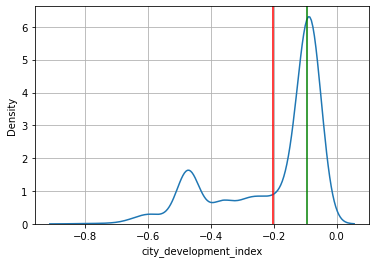

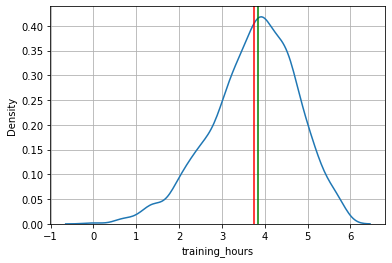

In [131]:
# Trying Log tranformation on the numeric features to check skewness and distribution
for i in numtest:
    sns.distplot(np.log(numtest[i]),hist=False)
    plt.axvline(np.mean(np.log(numtest[i])),color='red')
    plt.axvline(np.median(np.log(numtest[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

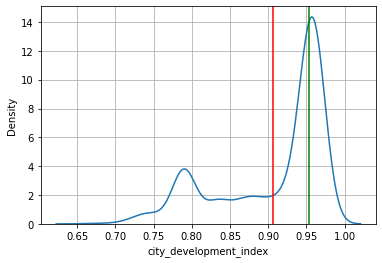

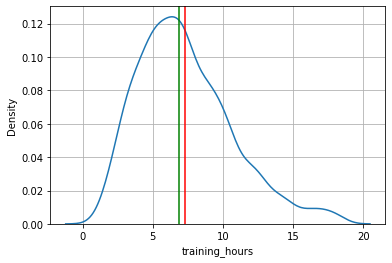

In [132]:
# Trying sqrt tranformation on the numeric features to check skewness and distribution
for i in numtest:
    sns.distplot(np.sqrt(numtest[i]),hist=False)
    plt.axvline(np.mean(np.sqrt(numtest[i])),color='red')
    plt.axvline(np.median(np.sqrt(numtest[i])),color='green')
    
    plt.xlabel(i)
    plt.grid()
    plt.show()

In [133]:
# Transforming numeric test data using boxcox
for i in numtest:
    numtest[i]=stats.boxcox(numtest[i])[0]
numtest.head()

,city_development_index,training_hours
0,-0.115672,3.991609
1,-0.066268,6.952814
2,-0.162621,3.441983
3,-0.115672,5.089015
4,-0.066268,6.296315


In [134]:
# Updating these transformations onto the test set
for i in numtest:
    test[i]=numtest[i]
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,-0.115672,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,3.991609
1,9858,city_103,-0.066268,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,6.952814
2,31806,city_21,-0.162621,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,3.441983
3,27385,city_13,-0.115672,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,5.089015
4,27724,city_103,-0.066268,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,6.296315


In [135]:
# Scalling these transformed numeric features
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

test[numtest.columns]=sc.fit_transform(test[numtest.columns])
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,-0.381734,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,-0.769930
1,9858,city_103,0.826549,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,0.838316
2,31806,city_21,-1.529930,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,-1.068434
3,27385,city_13,-0.381734,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,-0.173923
4,27724,city_103,0.826549,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,0.481768


In [136]:
test.shape

(2018, 13)

In [137]:
100*(test.isnull().sum()/len(test))

enrollee_id                0.000000
city                       0.000000
city_development_index     0.000000
gender                    21.952428
relevent_experience        0.000000
enrolled_university        0.000000
education_level            0.000000
major_discipline          12.338949
experience                 0.000000
company_size              28.592666
company_type              28.691774
last_new_job               0.000000
training_hours             0.000000
dtype: float64

In [138]:
# Categoric Data
categtest=test.select_dtypes(include='object')
categtest.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,city_41,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1
1,city_103,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1
2,city_21,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never
3,city_13,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1
4,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4


In [139]:
categtest.shape

(2018, 10)

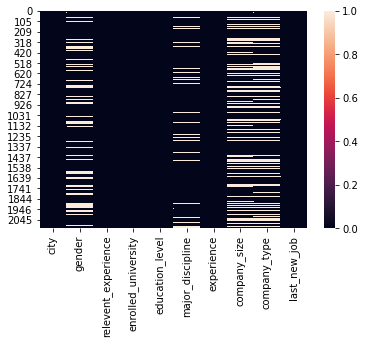

In [140]:
sns.heatmap(categtest.isnull())
plt.show()

In [141]:
propnctest=categtest.isnull().sum()/len(test)
propnctest

city                   0.000000
gender                 0.219524
relevent_experience    0.000000
enrolled_university    0.000000
education_level        0.000000
major_discipline       0.123389
experience             0.000000
company_size           0.285927
company_type           0.286918
last_new_job           0.000000
dtype: float64

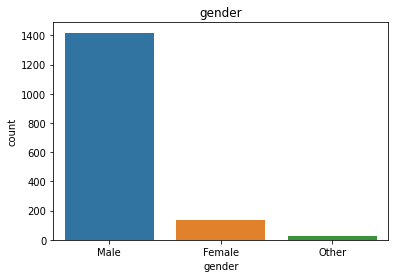

        Proportion % 
Male        70.267592
Female       6.640238
Other        1.139742


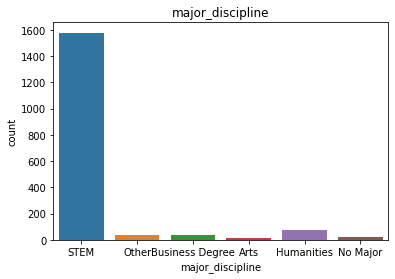

                 Proportion % 
STEM                 78.146680
Humanities            3.914767
Other                 1.932607
Business Degree       1.833499
No Major              0.991080
Arts                  0.842418


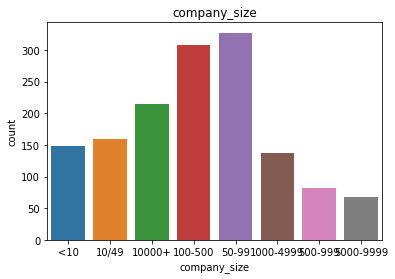

           Proportion % 
50-99          16.204163
100-500        15.213082
10000+         10.604559
10/49           7.879088
<10             7.333994
1000-4999       6.788900
500-999         4.063429
5000-9999       3.320119


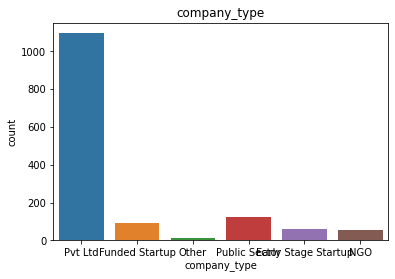

                     Proportion % 
Pvt Ltd                  54.261645
Public Sector             6.144698
Funded Startup            4.658077
Early Stage Startup       3.072349
NGO                       2.626363
Other                     0.545094


In [142]:
# Univariate analysis on categoric features with more than 10% null values
# Percentage Proportion of categoric groups in the feature with null>10% for identiying dominant groups

nctest=propnctest[propnctest>0.1].index # Index of categoric features with more than 10% null values
for i in nctest:
    plt.title(i)
    sns.countplot(categtest[i])
    plt.show()
    a=100*categtest[i].value_counts()/len(categtest)
    a=pd.DataFrame(a).rename({i:'Proportion % '},axis=1)
    print(a)

In [143]:
# Identifying the most Dominant categories in each feature dominating more than 50% of the total counts of that feature

domintest=[] # List of the most Dominant categories in each feature dominating more than 50% of the total counts of that feature
dfeattest=[] # Features associated with these 'most' dominant categories

ndfeattest=[] # Features that had most dominant category not being so dominant (less than 50%) 

for i in nctest:                    # nc is the index of categorical features with >10% null
    maxitest=categtest[i].value_counts().max()    # Count of the most dominant group
    domtest=categtest[i].value_counts().idxmax()  # Most dominant group in the feature
    
    if maxitest/len(categtest)>=0.5:    # Filtering out ONLY those dominant categories that dominate >=50% proportion in that feature
        domintest.append(domtest)
        dfeattest.append(i)
    else:
        ndfeattest.append(i)
        
mstdmnttest=pd.DataFrame({'Most Dominant Categories':domintest,'Feature':dfeattest}) # Tabular representation of dominant categories and the features that contain them
print(mstdmnttest)
print()
print('Features with not so dominant labels: ',ndfeattest) # List of features with 'not so dominant' dominant labels

  Most Dominant Categories           Feature
0                     Male            gender
1                     STEM  major_discipline
2                  Pvt Ltd      company_type

Features with not so dominant labels:  ['company_size']


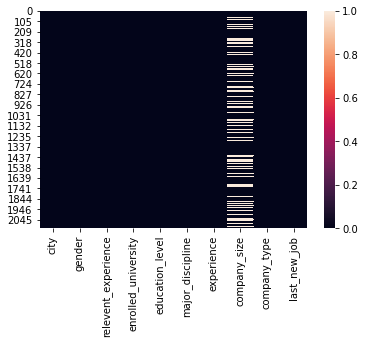

In [144]:
# Replacing Null of features with the 'most' dominant categories for features with dominant class that occupies more than 50% of the feature

categtest=test.select_dtypes(include='object')

for i in mstdmnttest.values:
    categtest[i[1]].fillna(i[0],inplace=True)

sns.heatmap(categtest.isnull())
plt.show()

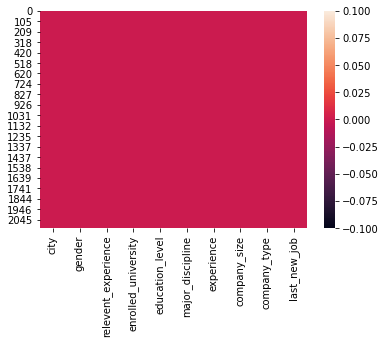

In [145]:
# Replacing null of features as 'OTHERS' for those features whose most dominant class is 'not so dominant' (ei occupy less than 50%)

for i in ndfeattest: # List of features with 'not so dominant' dominant labels
    categtest[i].fillna('OTHERS',inplace=True)

sns.heatmap(categtest.isnull())
plt.show()

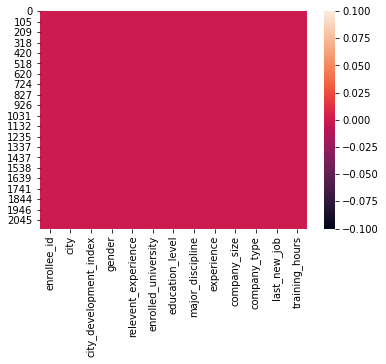

In [146]:
# Updating test set with clean categoric features
test[categtest.columns]=categtest

sns.heatmap(test.isnull())
plt.show()

In [147]:
test.shape

(2018, 13)

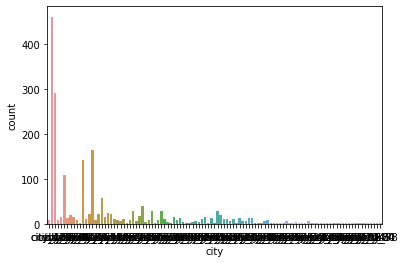

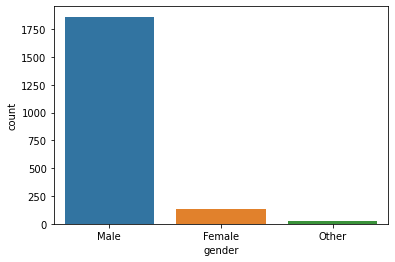

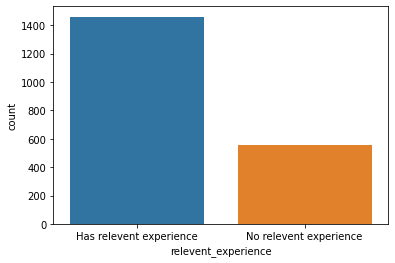

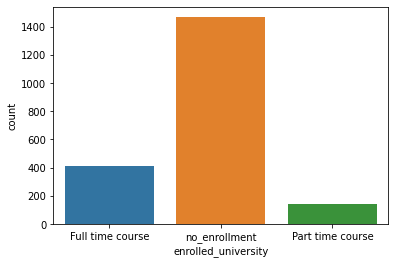

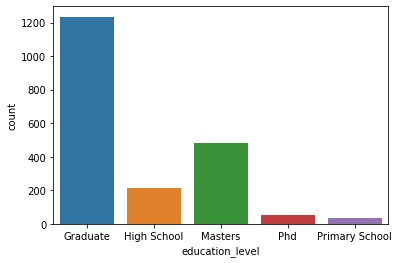

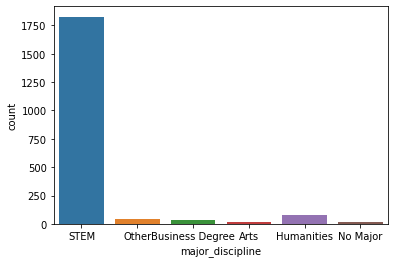

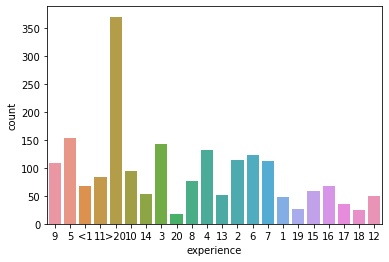

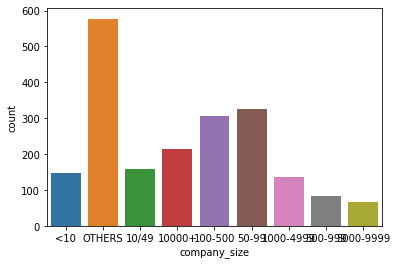

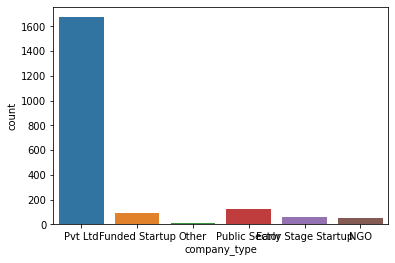

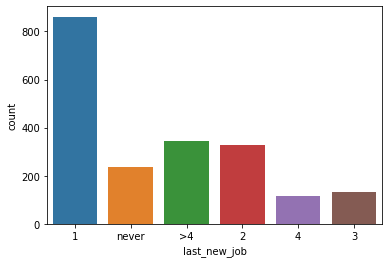

In [148]:
# Univariate analysis of all categorical features to get an idea of number of levels
for i in categtest:
    sns.countplot(categtest[i])
    plt.show()

In [149]:
desctest=categtest.describe()
desctest

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,2018,2018,2018,2018,2018,2018,2018,2018,2018,2018
unique,107,3,2,3,5,6,22,9,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,OTHERS,Pvt Ltd,1
freq,461,1861,1460,1469,1234,1826,371,577,1674,861


In [150]:
# Number of levels in each category
n_grptest=pd.DataFrame(desctest.iloc[1,:],index=desctest.columns).rename({'unique':'Number of levels'},axis=1)
n_grptest

,Number of levels
city,107
gender,3
relevent_experience,2
enrolled_university,3
education_level,5
major_discipline,6
experience,22
company_size,9
company_type,6
last_new_job,6


In [151]:
# Filtering out features with more than 6 levels
manylevelfeattest=n_grptest[n_grptest['Number of levels']>6]

colpstest=list(manylevelfeattest.index)   # Names of features with more than 6 levels (to be collapsed)

print(manylevelfeattest)
print()
print('Features to be collapsed:',colpstest) 

             Number of levels
city                      107
experience                 22
company_size                9

Features to be collapsed: ['city', 'experience', 'company_size']


 Elbow plot to check alternate number of levels to represent these feature :

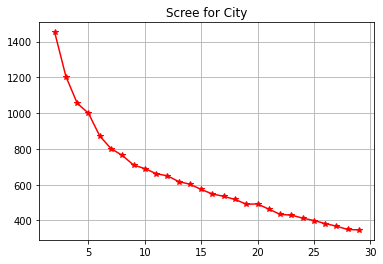

In [152]:
from sklearn.cluster import KMeans

dumcitytest=pd.get_dummies(categtest['city'],drop_first=True)

inert_citytest=[]
for k in range(2,30):
    kcitytest=KMeans(k)
    kcitytest.fit(dumcitytest)
    
    inert_citytest.append(kcitytest.inertia_)

plt.title('Scree for City')
plt.plot(range(2,30),inert_citytest,color='red',marker='*')
plt.grid()
plt.show()

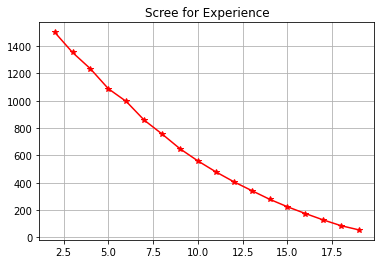

In [153]:
dumexptest=pd.get_dummies(categtest['experience'],drop_first=True)

inert_exptest=[]
for k in range(2,20):
    kexptest=KMeans(k)
    kexptest.fit(dumexptest)
    
    inert_exptest.append(kexptest.inertia_)
    
plt.title('Scree for Experience')
plt.plot(range(2,20),inert_exptest,color='red',marker='*')
plt.grid()
plt.show()

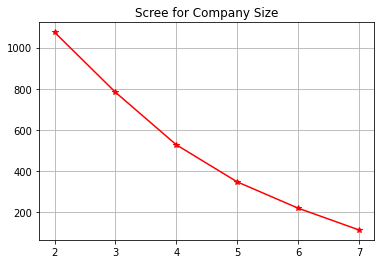

In [154]:
dumcpsizetest=pd.get_dummies(categtest['company_size'],drop_first=True)

inert_cpsztest=[]
for k in range(2,8):
    kcpsztest=KMeans(k)
    kcpsztest.fit(dumcpsizetest)
    
    inert_cpsztest.append(kcpsztest.inertia_)

plt.title('Scree for Company Size')
plt.plot(range(2,8),inert_cpsztest,color='red',marker='*')
plt.grid()
plt.show()

In [155]:
# Collapsed city from 107 to 15 levels
kmeancitytest=KMeans(n_clusters=15)
kmeancitytest.fit(dumcitytest)

citytest=kmeancitytest.labels_
citytest

array([0, 1, 2, ..., 0, 0, 0], dtype=int32)

In [156]:
# Collapsed experience from 22 to 10 levels
kmeanexptest=KMeans(n_clusters=10)
kmeanexptest.fit(dumexptest)

exptest=kmeanexptest.labels_
exptest

array([7, 4, 9, ..., 1, 6, 9], dtype=int32)

In [157]:
# Collapsed company size from 9 to 5 levels
kmeancpsizetest=KMeans(n_clusters=5)
kmeancpsizetest.fit(dumcpsizetest)

cpsizetest=kmeancpsizetest.labels_
cpsizetest

array([1, 2, 2, ..., 2, 3, 4], dtype=int32)

In [158]:
categtest['city']=citytest
categtest['experience']=exptest
categtest['company_size']=cpsizetest

categtest.head()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
0,0,Male,Has relevent experience,Full time course,Graduate,STEM,7,1,Pvt Ltd,1
1,1,Female,Has relevent experience,no_enrollment,Graduate,STEM,4,2,Pvt Ltd,1
2,2,Male,No relevent experience,no_enrollment,High School,STEM,9,2,Pvt Ltd,never
3,0,Male,Has relevent experience,no_enrollment,Masters,STEM,9,1,Pvt Ltd,1
4,1,Male,Has relevent experience,no_enrollment,Graduate,STEM,0,4,Pvt Ltd,>4


In [159]:
categtest[colpstest].head()

,city,experience,company_size
0,0,7,1
1,1,4,2
2,2,9,2
3,0,9,1
4,1,0,4


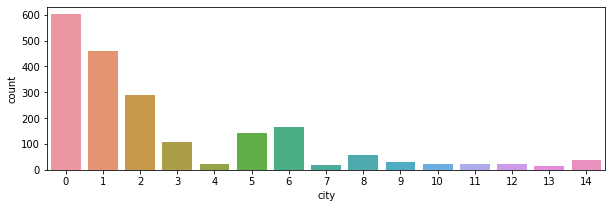

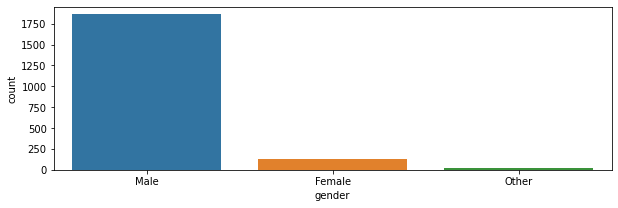

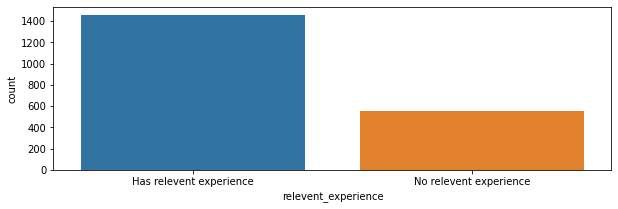

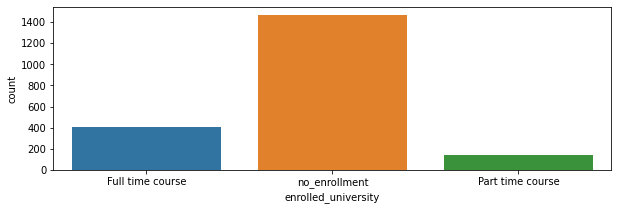

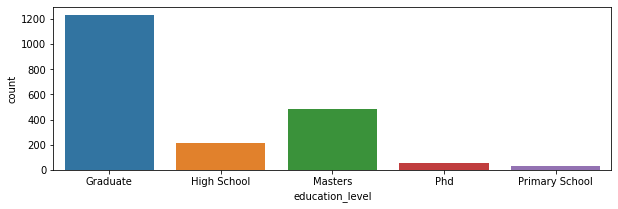

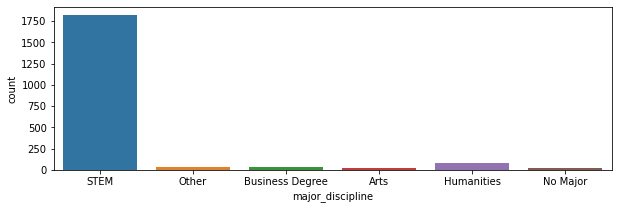

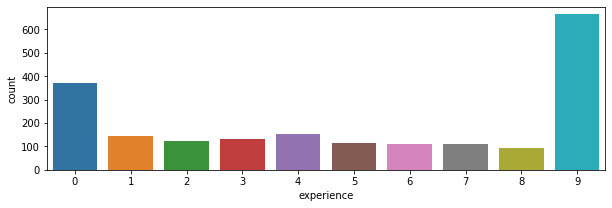

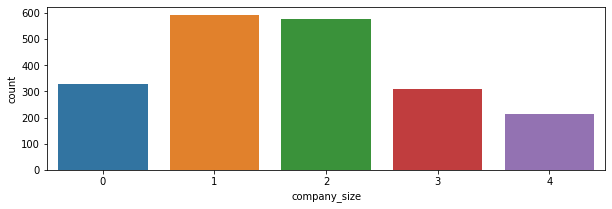

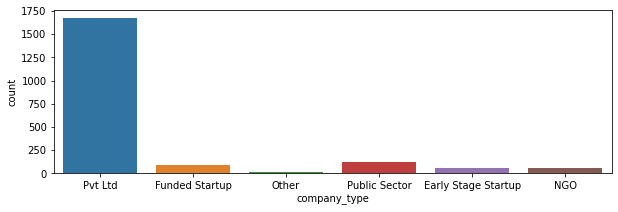

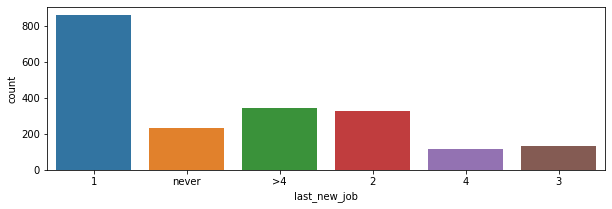

In [160]:
# Visualizing the label distributions among cateforic features after collapse (ALL categoric features included)
for i in categtest:
    plt.figure(figsize=(10,3))
    sns.countplot(categtest[i])
    plt.show()

In [161]:
# Final updation on the test set with collapsed features thier compressed levels
test[colpstest]=categtest[colpstest]
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,0,-0.381734,Male,Has relevent experience,Full time course,Graduate,STEM,7,1,Pvt Ltd,1,-0.769930
1,9858,1,0.826549,Female,Has relevent experience,no_enrollment,Graduate,STEM,4,2,Pvt Ltd,1,0.838316
2,31806,2,-1.529930,Male,No relevent experience,no_enrollment,High School,STEM,9,2,Pvt Ltd,never,-1.068434
3,27385,0,-0.381734,Male,Has relevent experience,no_enrollment,Masters,STEM,9,1,Pvt Ltd,1,-0.173923
4,27724,1,0.826549,Male,Has relevent experience,no_enrollment,Graduate,STEM,0,4,Pvt Ltd,>4,0.481768


In [162]:
# One-hot encoding of all categoric features of test set
test=pd.get_dummies(data=test,columns=list(categtest.columns),drop_first=True)
test.head()

,enrollee_id,city_development_index,training_hours,city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,gender_Male,gender_Other,relevent_experience_No relevent experience,enrolled_university_Part time course,enrolled_university_no_enrollment,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School,major_discipline_Business Degree,major_discipline_Humanities,major_discipline_No Major,major_discipline_Other,major_discipline_STEM,experience_1,experience_2,experience_3,experience_4,experience_5,experience_6,experience_7,experience_8,experience_9,company_size_1,company_size_2,company_size_3,company_size_4,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,32403,-0.381734,-0.769930,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,9858,0.826549,0.838316,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,31806,-1.529930,-1.068434,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,27385,-0.381734,-0.173923,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,27724,0.826549,0.481768,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [163]:
test.shape

(2018, 54)

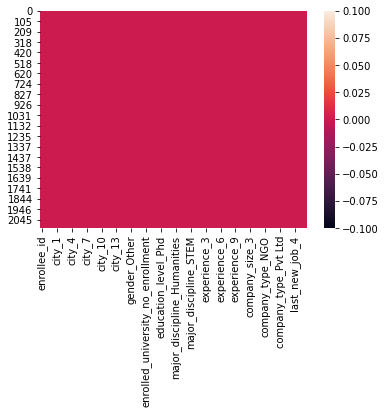

In [164]:
sns.heatmap(test.isnull())
plt.show()

# Final Predictions using the Final Model

In [174]:
Xtest=test.drop('enrollee_id',axis=1)
#print(Xtest)
Ypred= final.predict(Xtest)
#Ypred

ValueError: ignored

In [175]:
len(Ypred)==len(test)

NameError: ignored

In [176]:
# Important Features:
impo=pd.DataFrame(final.feature_importances_,index=Xtest.columns,columns=['Importance']).sort_values(by=['Importance'],ascending=False)
impo

,Importance
training_hours,0.166132
city_development_index,0.095342
education_level_Primary School,0.024693
company_size_2,0.024648
experience_8,0.021071
education_level_Phd,0.020467
education_level_Masters,0.019764
education_level_High School,0.019714
experience_6,0.018903
experience_1,0.018606
